In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle as astropy_ls
from scipy import optimize


import matplotlib 
matplotlib.rc('xtick', labelsize=27) 
matplotlib.rc('ytick', labelsize=27) 
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)




In [2]:
def get_chisq(observed_data, predicted_data, uncertainties):
    """
    Calculate the chi-square statistic for model evaluation.

    Parameters:
        observed_data (numpy array): Array of observed data points.
        predicted_data (numpy array): Array of model-predicted data points.
        uncertainties (numpy array): Array of uncertainties/standard deviations of the observed data.

    Returns:
        float: The chi-square statistic.
    """
    if len(observed_data) != len(predicted_data) or len(observed_data) != len(uncertainties):
        raise ValueError("All input arrays must have the same length.")

    squared_residuals = ((observed_data - predicted_data) ** 2. / (uncertainties ** 2.) )
    chi_square = np.sum(squared_residuals)

    return chi_square


def get_log_likelihood(chi_square):
    """
    Calculate the log-likelihood from the chi-square value.

    Parameters:
        chi_square (float): The chi-square value of the model.
        num_data_points (int): Number of data points (sample size).

    Returns:
        float: The log-likelihood.
    """
    log_likelihood = -0.5 * chi_square
    return log_likelihood

def get_BIC(num_params, num_data_points, log_likelihood):
    """
    Calculate the Bayesian Information Criterion (BIC).

    Parameters:
        num_params (int): Number of parameters in the model.
        num_data_points (int): Number of data points (sample size).
        log_likelihood (float): Log-likelihood of the model.

    Returns:
        float: The BIC value.
    """
    BIC = num_params * np.log(num_data_points) - 2 * log_likelihood
    return BIC



def get_AIC(observed, predicted, uncertainties, num_parameters):
    """
    Calculate the Akaike Information Criterion (AIC) for a model with data uncertainties.

    Parameters:
        observed (array-like): The observed data.
        predicted (array-like): The model's predicted values.
        uncertainties (array-like): The uncertainties on the observed data.
        num_parameters (int): The number of parameters in the model.

    Returns:
        float: The AIC value.
    """
    # Calculate the number of data points
    n = len(observed)

    # Calculate the weighted sum of squared residuals (RSS)
    residuals = np.array(observed) - np.array(predicted)
    rss = np.sum((residuals / uncertainties)**2)

    # Calculate the AIC value
    aic = n * np.log(rss / n) + 2 * num_parameters

    return aic


In [3]:
def get_times_null_model(epochs, T0, P): 
    """
    Generates null model times based on linear ephemeris.

    Parameters:
    - epochs (np.array): Array of epochs.
    - T0 (float): Reference time of the first transit.
    - P (float): Orbital period.

    Returns:
    - np.array: Array of null model times.
    """
    return T0 + P*epochs


def solve_null_model(epochs, times, times_err):
    """
    Solves for T0 and P in a null model using linear regression.

    Parameters:
    - epochs (np.array): Array of epochs.
    - times (np.array): Array of observed transit times.
    - times_err (np.array): Array of errors associated with observed transit times.

    Returns:
    - Tuple: Tuple containing T0_fit (float) and P_fit (float), the fitted parameters.
    """
    
    # Constructing the design matrix A
    A = np.column_stack([
        np.ones_like(epochs),
        epochs
    ])

    # Constructing the weight matrix W using times_err
    W = np.diag(1.0 / times_err**2.)

    # Constructing the observed times vector y
    y = times

    # Calculating the parameters using np.linalg.solve
    parameters = np.linalg.solve(A.T @ W @ A, A.T @ W @ y)

    T0_fit, P_fit = parameters

    return T0_fit, P_fit

In [4]:
def get_times_n_waves(epochs, T0, P, P_LS_ttv, *fourier_params):
    """
    Calculate the time as a function of epochs with multiple waves.

    Parameters:
    - epochs: array-like, time values
    - T0: float, reference time
    - P: float, linear period
    - P_LS_ttv: float, period for the last wave
    - *fourier_params: variable number of Fourier parameters for each wave

    Returns:
    - times: array-like, calculated times
    """

    # Determine the number of waves
    n = (len(fourier_params) + 1) // 3

    # Calculate linear component
    linear = T0 + P * epochs

    # Initialize the total wave component
    waves = 0

    # Iterate through waves
    for ii in range(n - 1):
        alpha_i_ttv, beta_i_ttv, P_i_ttv = fourier_params[3 * ii: 3 * (ii + 1)]

        # Calculate wave for the current Fourier parameters
        wave_i = alpha_i_ttv * np.sin((2 * np.pi * epochs / P_i_ttv)) + beta_i_ttv * np.cos((2 * np.pi * epochs / P_i_ttv))

        # Add the current wave to the total
        waves += wave_i

    # Calculate the last wave separately
    alpha_LS_ttv, beta_LS_ttv = fourier_params[3 * (n - 1): 3 * n]
    wave_LS = alpha_LS_ttv * np.sin((2 * np.pi * epochs / P_LS_ttv)) + beta_LS_ttv * np.cos((2 * np.pi * epochs / P_LS_ttv))
    waves += wave_LS

    # Combine linear and wave components to get the final result
    times = linear + waves

    return times


In [5]:
def hill_stability_check(mu1, mu2, P1, P2, e1, e2):

	'''
	tests Petit et al. (2018) Hill criterion
	planet 1 needs to be the inner

	Inputs
	mu1, mu2: mp/mstar
	P1, P2: periods
	e1, e2: eccenticities

	Outputs
	Hill_stable: Boolean of whether the system is Hill stable

	'''

	gamma = (mu1/mu2)
	P1P2third = (P1/P2)**(1/3)
	alpha = P1P2third**(2)
	epsilon = mu1 + mu2
	e1x = np.sqrt( 1. - e1**(2) )
	e2x = np.sqrt( 1. - e2**(2) )

	# C of the system, Eq 23 of Petit et al. (2018)
	inc1 = 0. # coplanar approx
	inc2 = 0. # coplanar approx
	Csys = gamma*P1P2third*( 1. - e1x*np.cos(inc1) ) + 1. - e2x*np.cos(inc2)

	# Critical C, Eq 26 of Petit et al. (2018)
	k1 = 3**(4/3)
	Ccrit = ( k1*epsilon**(2/3)*gamma )/( 1. + gamma )**(2)
	Ccrit = (alpha/(gamma+alpha))*(1.+Ccrit)
	Ccrit = gamma*P1P2third + 1. - np.sqrt( (1.+gamma)**(3)*Ccrit )


	if Csys < Ccrit:
		Hill_stable = True
	else:
		Hill_stable = False


	return Hill_stable















def chaos_stability_check(mu1, mu2, P1, P2, e1, e2, w1, w2):

	'''
	as presented in Tamayo et al 2021, 
	https://iopscience.iop.org/article/10.3847/0004-637X/823/2/118/pdf
	but originally from Hadden and Lithwick 2018...
	https://iopscience.iop.org/article/10.3847/1538-3881/aad32c/pdf

	tests Hadden & Lithwick (2018) chaos criterion
	technically 1 is inner planet, 2 is outer planet, but we use an abs
	function around the a2-a1 functions which should remove this issue
	because cos(x) is symmetric about x too

	Inputs
	mu1, mu2: mp/mstar
	P1, P2: periods
	e1, e2: eccenticities
	w1, w2: varpi of each planet... longitude of perihelion = omega + Omega

	Outputs
	non_chaotic: Boolean of whether the system is NOT chaotic

	'''
	
	roothalf = np.sqrt(1./2.)
	third = 1./3.
	twothirds = 2./3.
	fourthirds = 4./3.
	

	# Z of the system, Eq 16 of Hadden & Lithwick (2018)
	Zsys = roothalf*np.sqrt( e1**2 + e2**2 - ( 2.*e1*e2*np.cos(w1-w2) ) )

	# Not strictly true, but OK since we only ever use a1/a2 ratios
	a1 = P1**(twothirds)
	a2 = P2**(twothirds)

	# Critical Z, Eq 19 of Hadden & Lithwick (2018)
	Zcrit = -2.2*(mu1+mu2)**third*np.absolute(a2/(a2-a1))**fourthirds
	Zcrit = roothalf*np.absolute((a2-a1)/a1)*np.exp( Zcrit )

	if Zsys < Zcrit: 
		non_chaotic = True
	else:
		non_chaotic = False


	return non_chaotic




In [15]:
import csv
import ast
import os
from ast import literal_eval


directories1 = [
    './jup_jup/20240816_1/',
    './jup_jup/20240816_2/'
            ]

directories2 = [
    './earth_jup/20240816_1/',
    './earth_jup/20240816_2/'
            ]

directories3 = [
    './earth_earth/20240816_1/',
    './earth_earth/20240816_2/'
            ]


directories4 = [
    './jup_earth/20240816_1/',
    './jup_earth/20240816_2/'
            ]







In [16]:
lstsq_ppert_all1 = []
lstsq_ptrans_all1 = []
input_pperts_all1 = []
for directory in directories1:
    for csv_file in ['lstsq_ppert.csv']:
        csv_file_path = directory+csv_file
        # Get the size of the file in bytes
        file_size = os.path.getsize(csv_file_path)
        csv.field_size_limit(file_size)

        # Read the contents of the CSV file
        with open(csv_file_path, 'r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)

            # Assuming there is only one row in the CSV file
            for row in csv_reader:
                # Convert the string representation of a list to a list using ast.literal_eval
                list_of_lists = [literal_eval(item) for item in row]

                # Append the lists to the result
                lstsq_ppert = list_of_lists
        lstsq_ppert_all1.append(lstsq_ppert)
                

    for csv_file in ['lstsq_ptrans.csv']:
        csv_file_path = directory+csv_file
        # Get the size of the file in bytes
        file_size = os.path.getsize(csv_file_path)
        csv.field_size_limit(file_size)

        # Read the contents of the CSV file
        with open(csv_file_path, 'r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)

            # Assuming there is only one row in the CSV file
            for row in csv_reader:
                # Convert the string representation of a list to a list using ast.literal_eval
                list_of_lists = [literal_eval(item) for item in row]

                # Append the lists to the result
                lstsq_ptrans = list_of_lists
        lstsq_ptrans_all1.append(lstsq_ptrans)
            
       
    
    for csv_file in ['pperts.csv']:
        csv_file_path = directory+csv_file
        # Get the size of the file in bytes
        file_size = os.path.getsize(csv_file_path)
        csv.field_size_limit(file_size)

        # Read the contents of the CSV file
        with open(csv_file_path, 'r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)

            # Assuming there is only one row in the CSV file
            for row in csv_reader:
                # Convert the string representation of a list to a list using ast.literal_eval
                list_of_lists = [literal_eval(item) for item in row]

                # Append the lists to the result
                input_pperts = list_of_lists
        input_pperts_all1.append(input_pperts)
        
        
        
transit_times_pert_all1 = []
transit_times_trans_all1 = []

for directory in directories1:
    for csv_file in ['transit_times_pert.csv']:
        csv_file_path = directory+csv_file
        # Get the size of the file in bytes
        file_size = os.path.getsize(csv_file_path)
        csv.field_size_limit(file_size)

        # Read the contents of the CSV file
        with open(csv_file_path, 'r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)

            # Assuming there is only one row in the CSV file
            for row in csv_reader:
                # Convert the string representation of a list to a list using ast.literal_eval
                list_of_lists = [literal_eval(item) for item in row]

                # Append the lists to the result
                transit_times_pert = list_of_lists
                
        transit_times_pert_all1.append(transit_times_pert)


    for csv_file in ['transit_times_trans.csv']:
        csv_file_path = directory+csv_file
        # Get the size of the file in bytes
        file_size = os.path.getsize(csv_file_path)
        csv.field_size_limit(file_size)

        # Read the contents of the CSV file
        with open(csv_file_path, 'r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)

            # Assuming there is only one row in the CSV file
            for row in csv_reader:
                # Convert the string representation of a list to a list using ast.literal_eval
                list_of_lists = [literal_eval(item) for item in row]

                # Append the lists to the result
                transit_times_trans = list_of_lists
                
        transit_times_trans_all1.append(transit_times_trans)
        
        
        
        
        
        
        
#### optimized params are: T0, P, alpha_ttv, beta_ttv, P_ttv

optimized_params_all1 = []
alpha_1_ttv_all1 = []
beta_1_ttv_all1 = []
P_1_ttv_all1 = []
amplitude_ttv_all1 = []

for directory in directories1:
    for csv_file in ['optimized_params.csv']:
        csv_file_path = directory+csv_file
        # Get the size of the file in bytes
        file_size = os.path.getsize(csv_file_path)
        csv.field_size_limit(file_size)

        # Read the contents of the CSV file
        with open(csv_file_path, 'r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)

            # Assuming there is only one row in the CSV file
            for row in csv_reader:
                # Convert the string representation of a list to a list using ast.literal_eval
                list_of_lists = [literal_eval(item) for item in row]

                # Append the lists to the result
                optimized_params = list_of_lists
        optimized_params_all1.append(optimized_params)


    # define empty lists
    alpha_1_ttv = []
    beta_1_ttv = []
    P_1_ttv = []
    amplitude_ttv = []
    
    #alpha_2_ttv = []
    #beta_2_ttv = []
    #P_2_ttv = []

    for ii in range(0, len(optimized_params)):
        # define empty lists
        alpha_1_ttv_sub = []
        beta_1_ttv_sub = []
        P_1_ttv_sub = []
        amplitude_sub = []
        for jj in range(0, len(optimized_params[ii])):
            alpha_1_ttv_sub.append(optimized_params[ii][jj][1][2])
            beta_1_ttv_sub.append(optimized_params[ii][jj][1][3])
            P_1_ttv_sub.append(optimized_params[ii][jj][1][4])
            amplitude_sub.append(np.sqrt(optimized_params[ii][jj][1][2]**2.+optimized_params[ii][jj][1][3]**2.)*24.*60.)

        alpha_1_ttv.append(alpha_1_ttv_sub)
        beta_1_ttv.append(beta_1_ttv_sub)
        P_1_ttv.append(P_1_ttv_sub)
        amplitude_ttv.append(amplitude_sub)
        
    alpha_1_ttv_all1.append(alpha_1_ttv)
    beta_1_ttv_all1.append(beta_1_ttv)
    P_1_ttv_all1.append(P_1_ttv)
    amplitude_ttv_all1.append(amplitude_ttv)





orbital_params_all1 = []
for directory in directories1:
    for csv_file in ['orbital_params.csv']:
        csv_file_path = directory+csv_file
        # Get the size of the file in bytes
        file_size = os.path.getsize(csv_file_path)
        csv.field_size_limit(file_size)

        # Read the contents of the CSV file
        with open(csv_file_path, 'r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)

            # Assuming there is only one row in the CSV file
            for row in csv_reader:


                # Convert the string representation of a list to a list using ast.literal_eval
                list_of_lists = [literal_eval(item) for item in row]
                # Append the lists to the result
                orbital_params = list_of_lists
    orbital_params_all1.append(orbital_params)

In [17]:
lstsq_ppert_all2 = []
lstsq_ptrans_all2 = []
input_pperts_all2 = []
for directory in directories2:
    for csv_file in ['lstsq_ppert.csv']:
        csv_file_path = directory+csv_file
        # Get the size of the file in bytes
        file_size = os.path.getsize(csv_file_path)
        csv.field_size_limit(file_size)

        # Read the contents of the CSV file
        with open(csv_file_path, 'r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)

            # Assuming there is only one row in the CSV file
            for row in csv_reader:
                # Convert the string representation of a list to a list using ast.literal_eval
                list_of_lists = [literal_eval(item) for item in row]

                # Append the lists to the result
                lstsq_ppert = list_of_lists
        lstsq_ppert_all2.append(lstsq_ppert)
                

    for csv_file in ['lstsq_ptrans.csv']:
        csv_file_path = directory+csv_file
        # Get the size of the file in bytes
        file_size = os.path.getsize(csv_file_path)
        csv.field_size_limit(file_size)

        # Read the contents of the CSV file
        with open(csv_file_path, 'r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)

            # Assuming there is only one row in the CSV file
            for row in csv_reader:
                # Convert the string representation of a list to a list using ast.literal_eval
                list_of_lists = [literal_eval(item) for item in row]

                # Append the lists to the result
                lstsq_ptrans = list_of_lists
        lstsq_ptrans_all2.append(lstsq_ptrans)
            
       
    
    for csv_file in ['pperts.csv']:
        csv_file_path = directory+csv_file
        # Get the size of the file in bytes
        file_size = os.path.getsize(csv_file_path)
        csv.field_size_limit(file_size)

        # Read the contents of the CSV file
        with open(csv_file_path, 'r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)

            # Assuming there is only one row in the CSV file
            for row in csv_reader:
                # Convert the string representation of a list to a list using ast.literal_eval
                list_of_lists = [literal_eval(item) for item in row]

                # Append the lists to the result
                input_pperts = list_of_lists
        input_pperts_all2.append(input_pperts)
        
        
        
transit_times_pert_all2 = []
transit_times_trans_all2 = []

for directory in directories2:
    for csv_file in ['transit_times_pert.csv']:
        csv_file_path = directory+csv_file
        # Get the size of the file in bytes
        file_size = os.path.getsize(csv_file_path)
        csv.field_size_limit(file_size)

        # Read the contents of the CSV file
        with open(csv_file_path, 'r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)

            # Assuming there is only one row in the CSV file
            for row in csv_reader:
                # Convert the string representation of a list to a list using ast.literal_eval
                list_of_lists = [literal_eval(item) for item in row]

                # Append the lists to the result
                transit_times_pert = list_of_lists
                
        transit_times_pert_all2.append(transit_times_pert)


    for csv_file in ['transit_times_trans.csv']:
        csv_file_path = directory+csv_file
        # Get the size of the file in bytes
        file_size = os.path.getsize(csv_file_path)
        csv.field_size_limit(file_size)

        # Read the contents of the CSV file
        with open(csv_file_path, 'r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)

            # Assuming there is only one row in the CSV file
            for row in csv_reader:
                # Convert the string representation of a list to a list using ast.literal_eval
                list_of_lists = [literal_eval(item) for item in row]

                # Append the lists to the result
                transit_times_trans = list_of_lists
                
        transit_times_trans_all2.append(transit_times_trans)
        
        
        
        
        
        
        
#### optimized params are: T0, P, alpha_ttv, beta_ttv, P_ttv

optimized_params_all2 = []
alpha_1_ttv_all2 = []
beta_1_ttv_all2 = []
P_1_ttv_all2 = []
amplitude_ttv_all2 = []

for directory in directories2:
    for csv_file in ['optimized_params.csv']:
        csv_file_path = directory+csv_file
        # Get the size of the file in bytes
        file_size = os.path.getsize(csv_file_path)
        csv.field_size_limit(file_size)

        # Read the contents of the CSV file
        with open(csv_file_path, 'r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)

            # Assuming there is only one row in the CSV file
            for row in csv_reader:
                # Convert the string representation of a list to a list using ast.literal_eval
                list_of_lists = [literal_eval(item) for item in row]

                # Append the lists to the result
                optimized_params = list_of_lists
        optimized_params_all2.append(optimized_params)


    # define empty lists
    alpha_1_ttv = []
    beta_1_ttv = []
    P_1_ttv = []
    amplitude_ttv = []
    
    #alpha_2_ttv = []
    #beta_2_ttv = []
    #P_2_ttv = []

    for ii in range(0, len(optimized_params)):
        # define empty lists
        alpha_1_ttv_sub = []
        beta_1_ttv_sub = []
        P_1_ttv_sub = []
        amplitude_sub = []
        for jj in range(0, len(optimized_params[ii])):
            alpha_1_ttv_sub.append(optimized_params[ii][jj][1][2])
            beta_1_ttv_sub.append(optimized_params[ii][jj][1][3])
            P_1_ttv_sub.append(optimized_params[ii][jj][1][4])
            amplitude_sub.append(np.sqrt(optimized_params[ii][jj][1][2]**2.+optimized_params[ii][jj][1][3]**2.)*24.*60.)

        alpha_1_ttv.append(alpha_1_ttv_sub)
        beta_1_ttv.append(beta_1_ttv_sub)
        P_1_ttv.append(P_1_ttv_sub)
        amplitude_ttv.append(amplitude_sub)
        
    alpha_1_ttv_all2.append(alpha_1_ttv)
    beta_1_ttv_all2.append(beta_1_ttv)
    P_1_ttv_all2.append(P_1_ttv)
    amplitude_ttv_all2.append(amplitude_ttv)





orbital_params_all2 = []
for directory in directories2:
    for csv_file in ['orbital_params.csv']:
        csv_file_path = directory+csv_file
        # Get the size of the file in bytes
        file_size = os.path.getsize(csv_file_path)
        csv.field_size_limit(file_size)

        # Read the contents of the CSV file
        with open(csv_file_path, 'r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)

            # Assuming there is only one row in the CSV file
            for row in csv_reader:


                # Convert the string representation of a list to a list using ast.literal_eval
                list_of_lists = [literal_eval(item) for item in row]
                # Append the lists to the result
                orbital_params = list_of_lists
    orbital_params_all2.append(orbital_params)


In [18]:
lstsq_ppert_all3 = []
lstsq_ptrans_all3 = []
input_pperts_all3 = []
for directory in directories3:
    for csv_file in ['lstsq_ppert.csv']:
        csv_file_path = directory + csv_file
        file_size = os.path.getsize(csv_file_path)
        csv.field_size_limit(file_size)

        with open(csv_file_path, 'r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)
            for row in csv_reader:
                list_of_lists = [literal_eval(item) for item in row]
                lstsq_ppert = list_of_lists
        lstsq_ppert_all3.append(lstsq_ppert)

    for csv_file in ['lstsq_ptrans.csv']:
        csv_file_path = directory + csv_file
        file_size = os.path.getsize(csv_file_path)
        csv.field_size_limit(file_size)

        with open(csv_file_path, 'r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)
            for row in csv_reader:
                list_of_lists = [literal_eval(item) for item in row]
                lstsq_ptrans = list_of_lists
        lstsq_ptrans_all3.append(lstsq_ptrans)

    for csv_file in ['pperts.csv']:
        csv_file_path = directory + csv_file
        file_size = os.path.getsize(csv_file_path)
        csv.field_size_limit(file_size)

        with open(csv_file_path, 'r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)
            for row in csv_reader:
                list_of_lists = [literal_eval(item) for item in row]
                input_pperts = list_of_lists
        input_pperts_all3.append(input_pperts)

transit_times_pert_all3 = []
transit_times_trans_all3 = []

for directory in directories3:
    for csv_file in ['transit_times_pert.csv']:
        csv_file_path = directory + csv_file
        file_size = os.path.getsize(csv_file_path)
        csv.field_size_limit(file_size)

        with open(csv_file_path, 'r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)
            for row in csv_reader:
                list_of_lists = [literal_eval(item) for item in row]
                transit_times_pert = list_of_lists
                
        transit_times_pert_all3.append(transit_times_pert)

    for csv_file in ['transit_times_trans.csv']:
        csv_file_path = directory + csv_file
        file_size = os.path.getsize(csv_file_path)
        csv.field_size_limit(file_size)

        with open(csv_file_path, 'r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)
            for row in csv_reader:
                list_of_lists = [literal_eval(item) for item in row]
                transit_times_trans = list_of_lists
                
        transit_times_trans_all3.append(transit_times_trans)

optimized_params_all3 = []
alpha_1_ttv_all3 = []
beta_1_ttv_all3 = []
P_1_ttv_all3 = []
amplitude_ttv_all3 = []

for directory in directories3:
    for csv_file in ['optimized_params.csv']:
        csv_file_path = directory + csv_file
        file_size = os.path.getsize(csv_file_path)
        csv.field_size_limit(file_size)

        with open(csv_file_path, 'r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)
            for row in csv_reader:
                list_of_lists = [literal_eval(item) for item in row]
                optimized_params = list_of_lists
        optimized_params_all3.append(optimized_params)

    alpha_1_ttv = []
    beta_1_ttv = []
    P_1_ttv = []
    amplitude_ttv = []

    for ii in range(0, len(optimized_params)):
        alpha_1_ttv_sub = []
        beta_1_ttv_sub = []
        P_1_ttv_sub = []
        amplitude_sub = []
        for jj in range(0, len(optimized_params[ii])):
            alpha_1_ttv_sub.append(optimized_params[ii][jj][1][2])
            beta_1_ttv_sub.append(optimized_params[ii][jj][1][3])
            P_1_ttv_sub.append(optimized_params[ii][jj][1][4])
            amplitude_sub.append(np.sqrt(optimized_params[ii][jj][1][2] ** 2 + optimized_params[ii][jj][1][3] ** 2) * 24. * 60.)

        alpha_1_ttv.append(alpha_1_ttv_sub)
        beta_1_ttv.append(beta_1_ttv_sub)
        P_1_ttv.append(P_1_ttv_sub)
        amplitude_ttv.append(amplitude_sub)
        
    alpha_1_ttv_all3.append(alpha_1_ttv)
    beta_1_ttv_all3.append(beta_1_ttv)
    P_1_ttv_all3.append(P_1_ttv)
    amplitude_ttv_all3.append(amplitude_ttv)

orbital_params_all3 = []
for directory in directories3:
    for csv_file in ['orbital_params.csv']:
        csv_file_path = directory + csv_file
        file_size = os.path.getsize(csv_file_path)
        csv.field_size_limit(file_size)

        with open(csv_file_path, 'r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)
            for row in csv_reader:
                list_of_lists = [literal_eval(item) for item in row]
                orbital_params = list_of_lists
    orbital_params_all3.append(orbital_params)


In [19]:
lstsq_ppert_all4 = []
lstsq_ptrans_all4 = []
input_pperts_all4 = []
for directory in directories4:
    for csv_file in ['lstsq_ppert.csv']:
        csv_file_path = directory + csv_file
        file_size = os.path.getsize(csv_file_path)
        csv.field_size_limit(file_size)

        with open(csv_file_path, 'r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)
            for row in csv_reader:
                list_of_lists = [literal_eval(item) for item in row]
                lstsq_ppert = list_of_lists
        lstsq_ppert_all4.append(lstsq_ppert)

    for csv_file in ['lstsq_ptrans.csv']:
        csv_file_path = directory + csv_file
        file_size = os.path.getsize(csv_file_path)
        csv.field_size_limit(file_size)

        with open(csv_file_path, 'r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)
            for row in csv_reader:
                list_of_lists = [literal_eval(item) for item in row]
                lstsq_ptrans = list_of_lists
        lstsq_ptrans_all4.append(lstsq_ptrans)

    for csv_file in ['pperts.csv']:
        csv_file_path = directory + csv_file
        file_size = os.path.getsize(csv_file_path)
        csv.field_size_limit(file_size)

        with open(csv_file_path, 'r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)
            for row in csv_reader:
                list_of_lists = [literal_eval(item) for item in row]
                input_pperts = list_of_lists
        input_pperts_all4.append(input_pperts)

transit_times_pert_all4 = []
transit_times_trans_all4 = []

for directory in directories4:
    for csv_file in ['transit_times_pert.csv']:
        csv_file_path = directory + csv_file
        file_size = os.path.getsize(csv_file_path)
        csv.field_size_limit(file_size)

        with open(csv_file_path, 'r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)
            for row in csv_reader:
                list_of_lists = [literal_eval(item) for item in row]
                transit_times_pert = list_of_lists
                
        transit_times_pert_all4.append(transit_times_pert)

    for csv_file in ['transit_times_trans.csv']:
        csv_file_path = directory + csv_file
        file_size = os.path.getsize(csv_file_path)
        csv.field_size_limit(file_size)

        with open(csv_file_path, 'r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)
            for row in csv_reader:
                list_of_lists = [literal_eval(item) for item in row]
                transit_times_trans = list_of_lists
                
        transit_times_trans_all4.append(transit_times_trans)

optimized_params_all4 = []
alpha_1_ttv_all4 = []
beta_1_ttv_all4 = []
P_1_ttv_all4 = []
amplitude_ttv_all4 = []

for directory in directories4:
    for csv_file in ['optimized_params.csv']:
        csv_file_path = directory + csv_file
        file_size = os.path.getsize(csv_file_path)
        csv.field_size_limit(file_size)

        with open(csv_file_path, 'r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)
            for row in csv_reader:
                list_of_lists = [literal_eval(item) for item in row]
                optimized_params = list_of_lists
        optimized_params_all4.append(optimized_params)

    alpha_1_ttv = []
    beta_1_ttv = []
    P_1_ttv = []
    amplitude_ttv = []

    for ii in range(0, len(optimized_params)):
        alpha_1_ttv_sub = []
        beta_1_ttv_sub = []
        P_1_ttv_sub = []
        amplitude_sub = []
        for jj in range(0, len(optimized_params[ii])):
            alpha_1_ttv_sub.append(optimized_params[ii][jj][1][2])
            beta_1_ttv_sub.append(optimized_params[ii][jj][1][3])
            P_1_ttv_sub.append(optimized_params[ii][jj][1][4])
            amplitude_sub.append(np.sqrt(optimized_params[ii][jj][1][2] ** 2 + optimized_params[ii][jj][1][3] ** 2) * 24. * 60.)

        alpha_1_ttv.append(alpha_1_ttv_sub)
        beta_1_ttv.append(beta_1_ttv_sub)
        P_1_ttv.append(P_1_ttv_sub)
        amplitude_ttv.append(amplitude_sub)
        
    alpha_1_ttv_all4.append(alpha_1_ttv)
    beta_1_ttv_all4.append(beta_1_ttv)
    P_1_ttv_all4.append(P_1_ttv)
    amplitude_ttv_all4.append(amplitude_ttv)

orbital_params_all4 = []
for directory in directories4:
    for csv_file in ['orbital_params.csv']:
        csv_file_path = directory + csv_file
        file_size = os.path.getsize(csv_file_path)
        csv.field_size_limit(file_size)

        with open(csv_file_path, 'r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)
            for row in csv_reader:
                list_of_lists = [literal_eval(item) for item in row]
                orbital_params = list_of_lists
    orbital_params_all4.append(orbital_params)


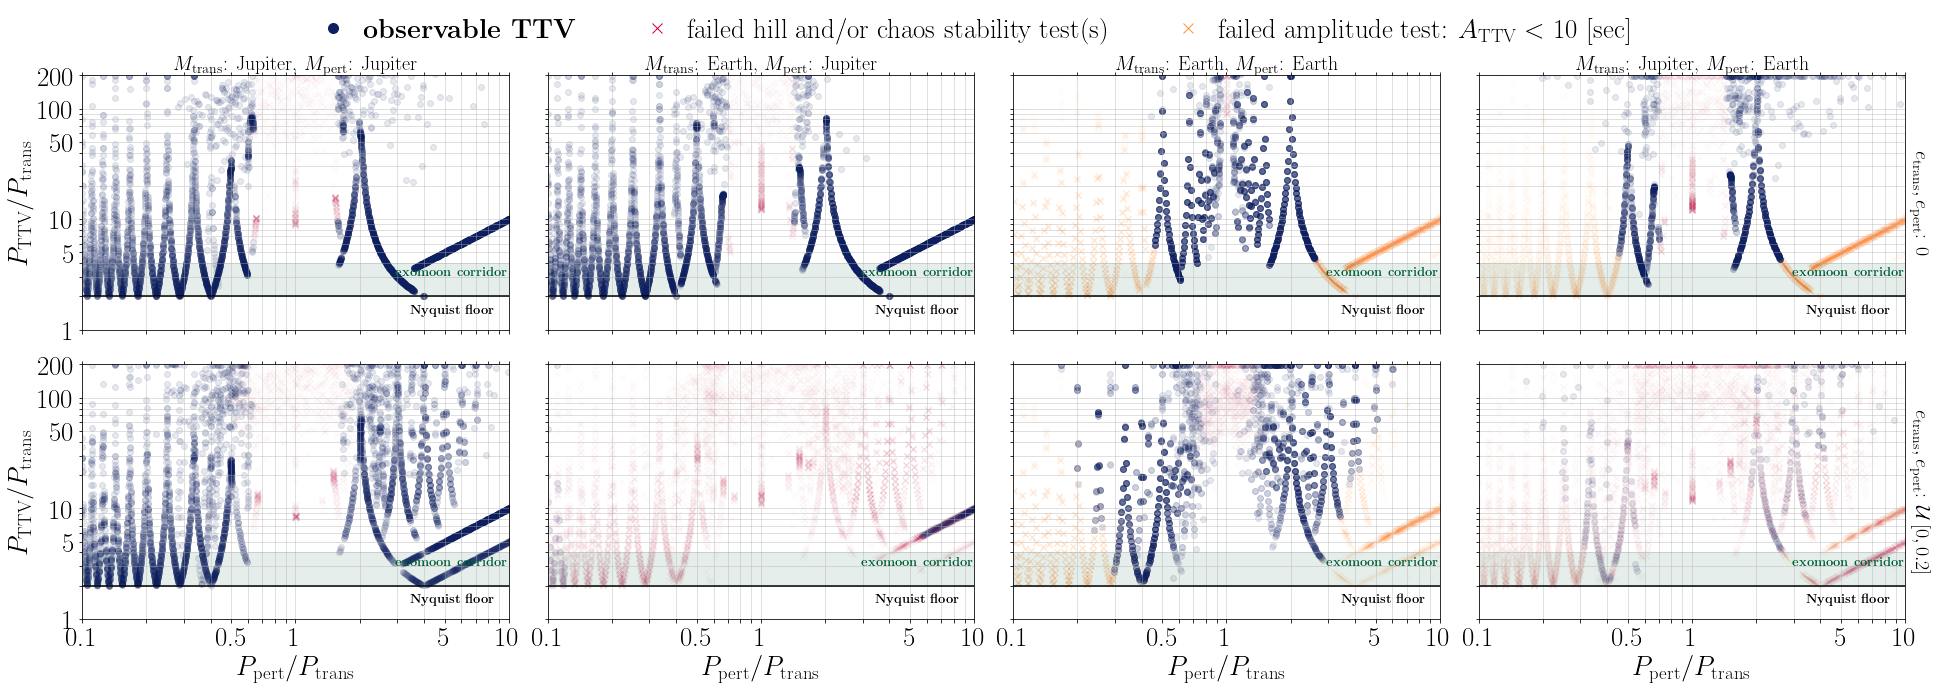

In [28]:
# Directories for each column
directories = [directories1, directories2, directories3, directories4]

# Corresponding data lists for each directory set
orbital_params_all = [orbital_params_all1, orbital_params_all2, orbital_params_all3, orbital_params_all4]
lstsq_ptrans_all = [lstsq_ptrans_all1, lstsq_ptrans_all2, lstsq_ptrans_all3, lstsq_ptrans_all4]
lstsq_ppert_all = [lstsq_ppert_all1, lstsq_ppert_all2, lstsq_ppert_all3, lstsq_ppert_all4]
P_1_ttv_all = [P_1_ttv_all1, P_1_ttv_all2, P_1_ttv_all3, P_1_ttv_all4]
amplitude_ttv_all = [amplitude_ttv_all1, amplitude_ttv_all2, amplitude_ttv_all3, amplitude_ttv_all4]

# Titles for each column
column_titles = [r'$M_\mathrm{trans}$: Jupiter, $M_\mathrm{pert}$: Jupiter', 
                 r'$M_\mathrm{trans}$: Earth, $M_\mathrm{pert}$: Jupiter', 
                 r'$M_\mathrm{trans}$: Earth, $M_\mathrm{pert}$: Earth', 
                 r'$M_\mathrm{trans}$: Jupiter, $M_\mathrm{pert}$: Earth']

# Labels for each row based on e ranges
row_labels = [r'$e_\mathrm{trans}, e_\mathrm{pert}$: 0', 
              r'$e_\mathrm{trans}, e_\mathrm{pert}$: $\mathcal{U} \, [0, 0.2]$']

# Number of subplots in the grid (rows = max length of directories, columns = 4)
n_rows = max(len(d) for d in directories)
n_cols = len(directories)

# Create a figure and a grid of subplots
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=[27, 9], sharex=True, sharey=True)

# Iterate over each directory and its corresponding data
for col, (dir_set, orbital_params, lstsq_ptrans, lstsq_ppert, P_1_ttv, amplitude_ttv) in enumerate(zip(directories, orbital_params_all, lstsq_ptrans_all, lstsq_ppert_all, P_1_ttv_all, amplitude_ttv_all)):
    for row in range(len(dir_set)):
        ax = axs[row, col] if n_rows > 1 else axs[col]  # Select the current subplot
        
        for ii in range(len(P_1_ttv[row])):
            hill_checks = []
            chaos_checks = []

            mu_trans = orbital_params[row][ii][0]
            mu_pert = orbital_params[row][ii][1]
            e_trans = orbital_params[row][ii][2]
            e_pert = orbital_params[row][ii][3]
            w_trans = orbital_params[row][ii][4]
            w_pert = orbital_params[row][ii][5]
            
            for jj in range(len(lstsq_ppert[row][ii])):
                P_trans = lstsq_ptrans[row][ii][jj]
                P_pert = lstsq_ppert[row][ii][jj]
                
                hill_check = hill_stability_check(mu_trans, mu_pert, P_trans, P_pert, e_trans, e_pert)
                chaos_check = chaos_stability_check(mu_trans, mu_pert, P_trans, P_pert, e_trans, e_pert, w_trans, w_pert)
                
                hill_checks.append(hill_check)
                chaos_checks.append(chaos_check)
            
            ppert_over_ptrans = np.array(lstsq_ppert[row][ii]) / np.array(lstsq_ptrans[row][ii])
            P1ttv = np.array(P_1_ttv[row][ii])
            amp_ttv = np.array(amplitude_ttv[row][ii])
            
            hill_checks = np.array(hill_checks)
            chaos_checks = np.array(chaos_checks)
            
            if hill_checks.size > 0 and chaos_checks.size > 0:
                # Find indices where both hill_check and chaos_check are True
                initial_selected_indices = np.where(hill_checks & chaos_checks)[0]
                
                if amp_ttv.size > 0:
                    # Further filter to include only where amplitude_ttv > 10/60 -- or 10 seconds
                    selected_indices = initial_selected_indices[amp_ttv[initial_selected_indices] > (10./60.)]
                    
                    # Determine indices excluded due to amplitude check
                    excluded_due_to_amplitude = np.setdiff1d(initial_selected_indices, selected_indices)
                    
                    # Determine indices failing due to stability checks
                    excluded_due_to_stability = np.setdiff1d(np.arange(ppert_over_ptrans.size), initial_selected_indices)
                else:
                    selected_indices = np.array([])
                    excluded_due_to_amplitude = initial_selected_indices
                    excluded_due_to_stability = np.arange(ppert_over_ptrans.size)
            else:
                selected_indices = np.array([])
                excluded_due_to_amplitude = np.array([])
                excluded_due_to_stability = np.arange(ppert_over_ptrans.size)
                
            # Plot the selected points
            if selected_indices.size > 0:
                ax.plot(ppert_over_ptrans[selected_indices], P1ttv[selected_indices], color='#0e1f60', alpha=.1, ls='', marker='o', zorder = 1)
            
            # Plot the non-selected points in red (due to stability checks)
            if excluded_due_to_stability.size > 0:
                ax.plot(ppert_over_ptrans[excluded_due_to_stability], P1ttv[excluded_due_to_stability], color='#d1003c', alpha=.03, ls='', marker='x', zorder=-10000)
                    
            # Plot the non-selected points in orange (due to amplitude checks)
            if excluded_due_to_amplitude.size > 0:
                ax.plot(ppert_over_ptrans[excluded_due_to_amplitude], P1ttv[excluded_due_to_amplitude], color='#ff9338', alpha=.03, ls='', marker='x', zorder=-10000)

        # plot Nyquist floor
        ax.axhline(2, 0, 1, color='k')
        ax.text(5.4, 1.4, r'\textbf{Nyquist floor}', fontsize=13, ha='center', color='k')

        # plot the exomoon corridor
        ax.axhspan(2, 4, 0, 1, color='#025f3a', alpha=.1)
        ax.text(5.4, 3.1, r'\textbf{exomoon corridor}', color= '#025f3a', fontsize=13, ha='center')
        

        # Set plot properties
        ax.set_yscale("log", base=10)
        ax.set_xscale("log", base=10)
        ax.set_xlim(.1, 10)
        ax.set_ylim(1, 200)
        ax.set_xticks([.1, .2, .3, .4, .5, .6, .7, .8, .9,
                       1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
        ax.set_xticklabels([.1, '', '', '', .5, '', '', '', '', 
                            1, '', '', '', 5, '', '', '', '', 10])
        ax.set_yticks([1, 2, 3, 4, 5, 6, 7, 8, 9,
                       10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200])
        ax.set_yticklabels([1, '', '', '', 5, '', '', '', '',
                            10, '', '', '', 50, '', '', '', '', 100, 200])
        ax.tick_params(axis='x', which='both', bottom=True, top=True)
        ax.tick_params(axis='y', which='both', bottom=True, top=True)
        
        if row == n_rows - 1:
            ax.set_xlabel(r'$P_\mathrm{pert}/P_\mathrm{trans}$', fontsize=27)
        if col == 0:
            ax.set_ylabel(r'$P_\mathrm{TTV}/P_\mathrm{trans}$', fontsize=27)
        
        ax.grid(True, alpha=0.5)
        
        # Annotate row labels on the right side
        if col == n_cols - 1:
            ax.annotate(row_labels[row], xy=(1.01, 0.5), xycoords='axes fraction', 
                        fontsize=20, ha='left', va='center', rotation=270)

    # Set the title for the top row subplots
    axs[0, col].set_title(column_titles[col], fontsize=20)

# Create a custom legend with alpha=1 for markers
legend_elements = [
    plt.Line2D([0], [0], color='#0e1f60', marker='o', linestyle='', markersize=10, label=r'\textbf{observable TTV}', alpha=1),
    plt.Line2D([0], [0], color='#d1003c', marker='x', linestyle='', markersize=10, label=r'failed hill and/or chaos stability test(s)', alpha=1),
    plt.Line2D([0], [0], color='#ff9338', marker='x', linestyle='', markersize=10, label=r'failed amplitude test: $A_\mathrm{TTV}$ $<$ 10 [sec]', alpha=1)
]

# Add the legend to the figure
fig.legend(handles=legend_elements, loc='upper center', fontsize=27, ncol=3, bbox_to_anchor=(0.5, 1.08), frameon=False, handletextpad=0.1)


# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.02, hspace=0.02)  # Modify wspace and hspace to reduce space between subplots



# Adjust layout to prevent overlap and fit the legend as the title
fig.tight_layout(rect=[0, 0, 1, 1])  # Adjust the top space to fit the legend

# Optionally save the figure
plt.savefig('./figures/exoplanet_edge.pdf', bbox_inches='tight')

# Show the plot
plt.show()



In [21]:
#super period
def super_period(P1, P2, j, k):
    return 1/np.abs((j/P1) - (k/P2))


#normalized super period to P1
def super_period_norm(P2P1, j, k):
    return 1/np.abs((j) - (k/P2P1))

#normalized super period to P1 and where n now represents the order
#n = 1 means j:j-1 orbit
#n = -1 means j:j+1 orbit
def super_period_norm_order(P2P1, j, n):
    return 1/np.abs((j) - (j-n/P2P1))


#we can solve for j as the nearest resonance to k... 
#since P1/P2 ~ j/k, then j ~ k*(P1/P2) = k/P2P1
def j_nearest_k(P2P1, k):
    return np.round(k/P2P1)

#we can solve for k as the nearest resonance to j... 
#since P1/P2 ~ j/k, then k ~ j/(P1/P2) = k*P2P1
def k_nearest_j(P2P1, k):
    return np.round(k * P2P1)


#aliasing formula
def alias_period(Pttv, m):
    return 1/np.abs((1/Pttv) + m)



#chopping period
def chopping_period(P1, P2):
    return 1/np.abs((1/P1) - (1/P2))


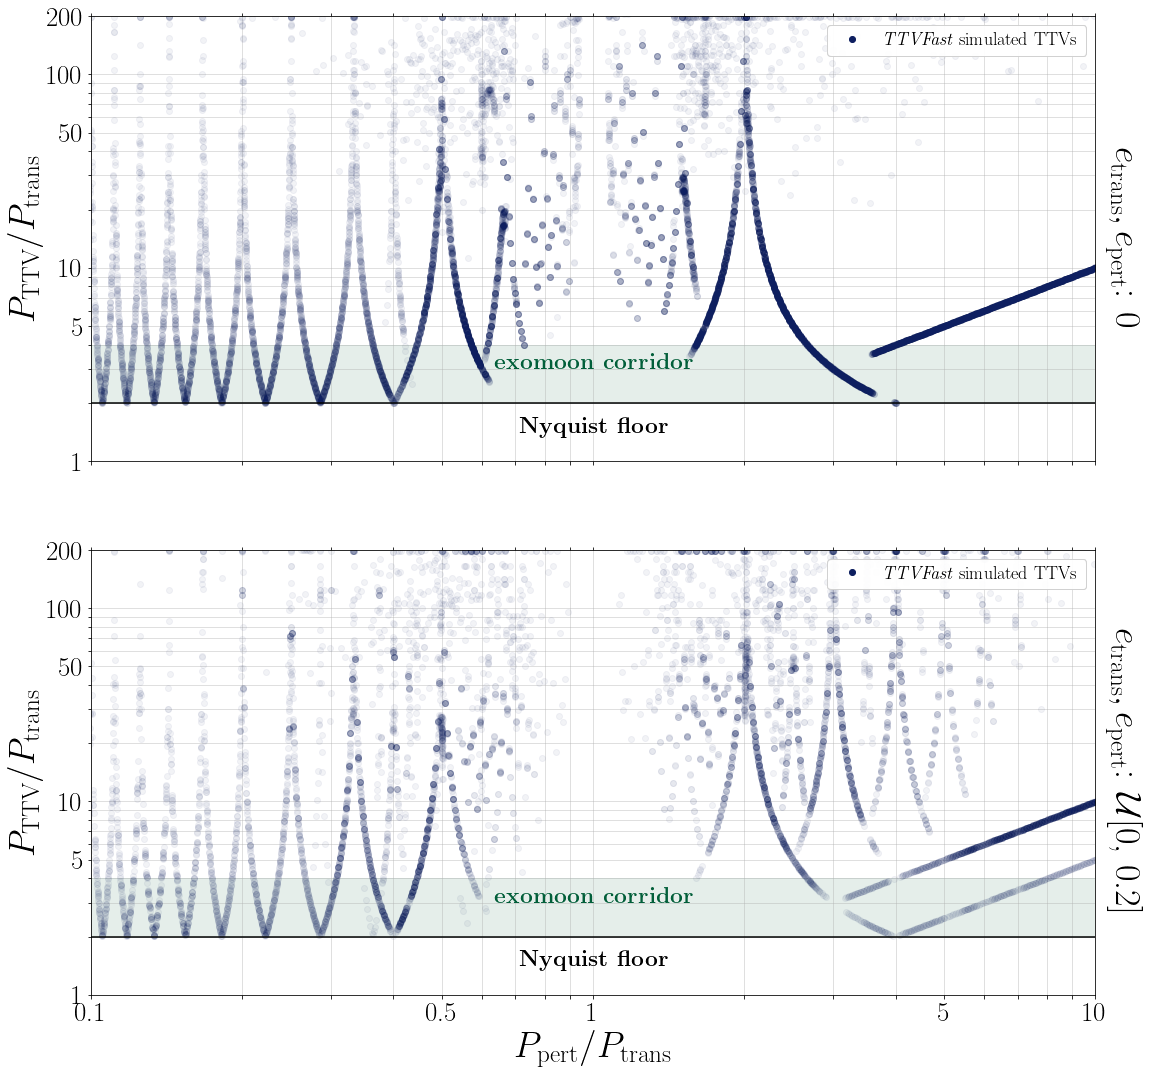

In [26]:
import matplotlib.lines as mlines

# Directories for each column
directories = [directories1, directories2, directories3, directories4]

# Corresponding data lists for each directory set
orbital_params_all = [orbital_params_all1, orbital_params_all2, orbital_params_all3, orbital_params_all4]
lstsq_ptrans_all = [lstsq_ptrans_all1, lstsq_ptrans_all2, lstsq_ptrans_all3, lstsq_ptrans_all4]
lstsq_ppert_all = [lstsq_ppert_all1, lstsq_ppert_all2, lstsq_ppert_all3, lstsq_ppert_all4]
P_1_ttv_all = [P_1_ttv_all1, P_1_ttv_all2, P_1_ttv_all3, P_1_ttv_all4]
amplitude_ttv_all = [amplitude_ttv_all1, amplitude_ttv_all2, amplitude_ttv_all3, amplitude_ttv_all4]

# Initialize lists to store combined filtered data
combined_ppert_over_ptrans = []
combined_P1ttv = []

# Create a figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=[18, 18], sharex=True)

# Subplot 1: plot e=0
for col, (dir_set, orbital_params, lstsq_ptrans, lstsq_ppert, P_1_ttv, amplitude_ttv) in enumerate(zip(directories, orbital_params_all, lstsq_ptrans_all, lstsq_ppert_all, P_1_ttv_all, amplitude_ttv_all)):
    for row in range(1):  # Adjust range to loop through the first 1 rows only
        for ii in range(len(P_1_ttv[row])):
            hill_checks = []
            chaos_checks = []

            mu_trans = orbital_params[row][ii][0]
            mu_pert = orbital_params[row][ii][1]
            e_trans = orbital_params[row][ii][2]
            e_pert = orbital_params[row][ii][3]
            w_trans = orbital_params[row][ii][4]
            w_pert = orbital_params[row][ii][5]

            for jj in range(len(lstsq_ppert[row][ii])):
                P_trans = lstsq_ptrans[row][ii][jj]
                P_pert = lstsq_ppert[row][ii][jj]

                hill_check = hill_stability_check(mu_trans, mu_pert, P_trans, P_pert, e_trans, e_pert)
                chaos_check = chaos_stability_check(mu_trans, mu_pert, P_trans, P_pert, e_trans, e_pert, w_trans, w_pert)

                hill_checks.append(hill_check)
                chaos_checks.append(chaos_check)

            ppert_over_ptrans = np.array(lstsq_ppert[row][ii]) / np.array(lstsq_ptrans[row][ii])
            P1ttv = np.array(P_1_ttv[row][ii])
            amp_ttv = np.array(amplitude_ttv[row][ii])

            hill_checks = np.array(hill_checks)
            chaos_checks = np.array(chaos_checks)

            if hill_checks.size > 0 and chaos_checks.size > 0:
                # Find indices where both hill_check and chaos_check are True
                initial_selected_indices = np.where(hill_checks & chaos_checks)[0]

                # Further filter to include only where amplitude_ttv > 10/60 -- or 10 seconds
                if amp_ttv.size > 0:
                    selected_indices = initial_selected_indices[amp_ttv[initial_selected_indices] > (10./60.)]

                    # Add selected data to combined lists
                    combined_ppert_over_ptrans.extend(ppert_over_ptrans[selected_indices])
                    combined_P1ttv.extend(P1ttv[selected_indices])

# Convert lists to numpy arrays for plotting
combined_ppert_over_ptrans = np.array(combined_ppert_over_ptrans)
combined_P1ttv = np.array(combined_P1ttv)

# Plot the combined filtered data in the first subplot
if combined_ppert_over_ptrans.size > 0 and combined_P1ttv.size > 0:
    line0 = axs[0].plot(combined_ppert_over_ptrans, combined_P1ttv, color='#0e1f60', alpha=.05, ls='', marker='o',
                        label = r'\textit{TTVFast} simulated TTVs')

# Repeat the above process for all rows in the second subplot
combined_ppert_over_ptrans = []
combined_P1ttv = []

 
    
# plot Nyquist floor
axs[0].axhline(2, 0, 1, color='k')
axs[0].text(1, 1.4, r'\textbf{Nyquist floor}', fontsize=23, ha='center', color='k')

# plot the exomoon corridor
axs[0].axhspan(2, 4, 0, 1, color='#025f3a', alpha=.1)
axs[0].text(1, 3, r'\textbf{exomoon corridor}', color= '#025f3a', fontsize=23, ha='center')



ecc_label = r'$e_\mathrm{trans}, e_\mathrm{pert}$: 0'
axs[0].annotate(ecc_label, xy=(1.01, 0.5), xycoords='axes fraction', fontsize=36, ha='left', va='center', rotation=270)









# Subplot 3: plot e=[0,0.2]
for col, (dir_set, orbital_params, lstsq_ptrans, lstsq_ppert, P_1_ttv, amplitude_ttv) in enumerate(zip(directories, orbital_params_all, lstsq_ptrans_all, lstsq_ppert_all, P_1_ttv_all, amplitude_ttv_all)):
    for row in range(1,2):  # Loop through all rows
        for ii in range(len(P_1_ttv[row])):
            hill_checks = []
            chaos_checks = []

            mu_trans = orbital_params[row][ii][0]
            mu_pert = orbital_params[row][ii][1]
            e_trans = orbital_params[row][ii][2]
            e_pert = orbital_params[row][ii][3]
            w_trans = orbital_params[row][ii][4]
            w_pert = orbital_params[row][ii][5]

            for jj in range(len(lstsq_ppert[row][ii])):
                P_trans = lstsq_ptrans[row][ii][jj]
                P_pert = lstsq_ppert[row][ii][jj]

                hill_check = hill_stability_check(mu_trans, mu_pert, P_trans, P_pert, e_trans, e_pert)
                chaos_check = chaos_stability_check(mu_trans, mu_pert, P_trans, P_pert, e_trans, e_pert, w_trans, w_pert)

                hill_checks.append(hill_check)
                chaos_checks.append(chaos_check)

            ppert_over_ptrans = np.array(lstsq_ppert[row][ii]) / np.array(lstsq_ptrans[row][ii])
            P1ttv = np.array(P_1_ttv[row][ii])
            amp_ttv = np.array(amplitude_ttv[row][ii])

            hill_checks = np.array(hill_checks)
            chaos_checks = np.array(chaos_checks)

            if hill_checks.size > 0 and chaos_checks.size > 0:
                # Find indices where both hill_check and chaos_check are True
                initial_selected_indices = np.where(hill_checks & chaos_checks)[0]

                # Further filter to include only where amplitude_ttv > 10/60 -- or 10 seconds
                if amp_ttv.size > 0:
                    selected_indices = initial_selected_indices[amp_ttv[initial_selected_indices] > (10./60.)]

                    # Add selected data to combined lists
                    combined_ppert_over_ptrans.extend(ppert_over_ptrans[selected_indices])
                    combined_P1ttv.extend(P1ttv[selected_indices])

# Convert lists to numpy arrays for plotting
combined_ppert_over_ptrans = np.array(combined_ppert_over_ptrans)
combined_P1ttv = np.array(combined_P1ttv)

# Plot the combined filtered data in the second subplot
if combined_ppert_over_ptrans.size > 0 and combined_P1ttv.size > 0:
    line0 = axs[1].plot(combined_ppert_over_ptrans, combined_P1ttv, color='#0e1f60', alpha=.05, ls='', marker='o', 
                        label = r'\textit{TTVFast} simulated TTVs')






    
# plot Nyquist floor
axs[1].axhline(2, 0, 1, color='k')
axs[1].text(1, 1.4, r'\textbf{Nyquist floor}', fontsize=23, ha='center', color='k')

# plot the exomoon corridor
axs[1].axhspan(2, 4, 0, 1, color='#025f3a', alpha=.1)
axs[1].text(1, 3, r'\textbf{exomoon corridor}', color= '#025f3a', fontsize=23, ha='center')


ecc_label = r'$e_\mathrm{trans}, e_\mathrm{pert}$: $\mathcal{U}$[0, 0.2]'
axs[1].annotate(ecc_label, xy=(1.01, 0.5), xycoords='axes fraction', fontsize=36, ha='left', va='center', rotation=270)

   
    
    
    
    
    
# Set plot properties
for ax in axs:
    ax.set_yscale("log", base=10)
    ax.set_xscale("log", base=10)
    ax.set_xlim(.1, 10)
    ax.set_ylim(1, 200)
    ax.set_xticks([.1, .2, .3, .4, .5, .6, .7, .8, .9,
                   1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
    ax.set_xticklabels([.1, '', '', '', .5, '', '', '', '', 
                        1, '', '', '', 5, '', '', '', '', 10])
    ax.set_yticks([1, 2, 3, 4, 5, 6, 7, 8, 9,
                   10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200])
    ax.set_yticklabels([1, '', '', '', 5, '', '', '', '',
                        10, '', '', '', 50, '', '', '', '', 100, 200])
    ax.tick_params(axis='x', which='both', bottom=True, top=True)
    ax.tick_params(axis='y', which='both', bottom=True, top=True)

    ax.grid(True, alpha=0.5)

axs[0].set_ylabel(r'$P_\mathrm{TTV}/P_\mathrm{trans}$', fontsize=36)
axs[1].set_ylabel(r'$P_\mathrm{TTV}/P_\mathrm{trans}$', fontsize=36)
axs[1].set_xlabel(r'$P_\mathrm{pert}/P_\mathrm{trans}$', fontsize=36)



# Custom proxy artist for the legend with alpha=1
ttvfast_legend_marker = mlines.Line2D([], [], color='#0e1f60', marker='o', linestyle='', alpha=1, label=r'\textit{TTVFast} simulated TTVs')

# Add the legend to top subplot
lines = [ttvfast_legend_marker]
labs = [line.get_label() for line in lines]
legend = axs[0].legend(lines, labs, loc=1, fontsize=18)
axs[0].add_artist(legend)

# Add the legend to middle subplot
lines = [ttvfast_legend_marker]
labs = [line.get_label() for line in lines]
legend = axs[1].legend(lines, labs, loc=1, fontsize=18)
axs[1].add_artist(legend)



# Optionally save the figure
plt.savefig('./figures/exoplanet_edge_combined.pdf', bbox_inches='tight')

# Show the plot
plt.show()
